In [69]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [106]:
root = r"C:\Users\Admin\Dropbox\PC\Documents\Anomaly Detection\AnoDDPM\DATASETS\brats2021\traning_data"

In [107]:
# hroot = os.path.join(root,"5k_Healthy")

In [126]:
path = r"C:\Users\Admin\Dropbox\PC\Documents\Anomaly Detection\AnoDDPM\DATASETS\brats2021\5k_Healthy.txt"

In [127]:
df = pd.read_csv(path)


In [129]:
arr = df.values

In [133]:
arr[0].

array(['C:\\Users\\Admin\\Dropbox\\PC\\Documents\\Anomaly Detection\\AnoDDPM\\DATASETS\\brats2021\\traning_data\\BraTS2021_00000/BraTS2021_00000+_Healthy_+46.npy'],
      dtype=object)

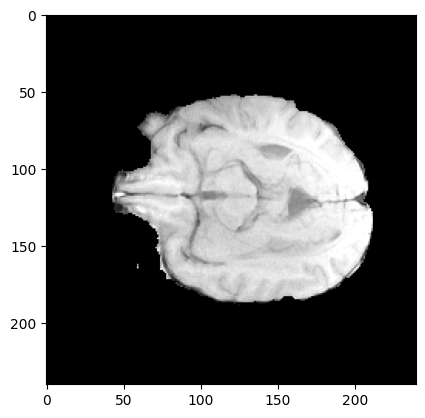

In [145]:
image = np.load(arr[7][0])
plt.imshow(image, cmap ='gray')

In [ ]:
import cv2

# Load the image as grayscale
img = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

# Display the image
cv2.imshow('Grayscale Image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [113]:
l = []
for i in range(len(df)):
    image = np.load(os.path.join(root,arr[i][0]))
    if image.mean()>0.2:
        l.append(os.path.join(root,arr[i][0]))

In [120]:
df = pd.DataFrame(l)

In [121]:
df

,0
0,C:\Users\Admin\Dropbox\PC\Documents\Anomaly De...
1,C:\Users\Admin\Dropbox\PC\Documents\Anomaly De...
2,C:\Users\Admin\Dropbox\PC\Documents\Anomaly De...
3,C:\Users\Admin\Dropbox\PC\Documents\Anomaly De...
4,C:\Users\Admin\Dropbox\PC\Documents\Anomaly De...
...,...
5072,C:\Users\Admin\Dropbox\PC\Documents\Anomaly De...
5073,C:\Users\Admin\Dropbox\PC\Documents\Anomaly De...
5074,C:\Users\Admin\Dropbox\PC\Documents\Anomaly De...
5075,C:\Users\Admin\Dropbox\PC\Documents\Anomaly De...


In [124]:
root = r"C:\Users\Admin\Dropbox\PC\Documents\Anomaly Detection\AnoDDPM\DATASETS\brats2021"
hroot = os.path.join(root,"5k_Healthy.txt")

In [125]:
df.to_csv(hroot, index=False)

In [44]:
image = np.load(os.path.join(root,arr[5000][0]))
image.mean()

0.11484449

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class MS_SSIM_L1_LOSS(nn.Module):
    # Have to use cuda, otherwise the speed is too slow.
    def __init__(self, gaussian_sigmas=[0.5, 1.0, 2.0, 4.0, 8.0],
                 data_range = 1.0,
                 K=(0.01, 0.03),
                 alpha=0.025,
                 compensation=200.0,
                ):
        super(MS_SSIM_L1_LOSS, self).__init__()
        self.DR = data_range
        self.C1 = (K[0] * data_range) ** 2
        self.C2 = (K[1] * data_range) ** 2
        self.pad = int(2 * gaussian_sigmas[-1])
        self.alpha = alpha
        self.compensation=compensation
        filter_size = int(4 * gaussian_sigmas[-1] + 1)
        g_masks = torch.zeros((3*len(gaussian_sigmas), 1, filter_size, filter_size))
        for idx, sigma in enumerate(gaussian_sigmas):
            # r0,g0,b0,r1,g1,b1,...,rM,gM,bM
            g_masks[3*idx+0, 0, :, :] = self._fspecial_gauss_2d(filter_size, sigma)
            g_masks[3*idx+1, 0, :, :] = self._fspecial_gauss_2d(filter_size, sigma)
            g_masks[3*idx+2, 0, :, :] = self._fspecial_gauss_2d(filter_size, sigma)
        self.g_masks = g_masks.to(device)

    def _fspecial_gauss_1d(self, size, sigma):
        """Create 1-D gauss kernel
        Args:
            size (int): the size of gauss kernel
            sigma (float): sigma of normal distribution

        Returns:
            torch.Tensor: 1D kernel (size)
        """
        coords = torch.arange(size).to(dtype=torch.float)
        coords -= size // 2
        g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
        g /= g.sum()
        return g.reshape(-1)

    def _fspecial_gauss_2d(self, size, sigma):
        """Create 2-D gauss kernel
        Args:
            size (int): the size of gauss kernel
            sigma (float): sigma of normal distribution

        Returns:
            torch.Tensor: 2D kernel (size x size)
        """
        gaussian_vec = self._fspecial_gauss_1d(size, sigma)
        return torch.outer(gaussian_vec, gaussian_vec)

    def forward(self, x, y):
        b, c, h, w = x.shape
        mux = F.conv2d(x, self.g_masks, groups=1, padding=self.pad)
        muy = F.conv2d(y, self.g_masks, groups=1, padding=self.pad)

        mux2 = mux * mux
        muy2 = muy * muy
        muxy = mux * muy

        sigmax2 = F.conv2d(x * x, self.g_masks, groups=1, padding=self.pad) - mux2
        sigmay2 = F.conv2d(y * y, self.g_masks, groups=1, padding=self.pad) - muy2
        sigmaxy = F.conv2d(x * y, self.g_masks, groups=1, padding=self.pad) - muxy

        # l(j), cs(j) in MS-SSIM
        l  = (2 * muxy    + self.C1) / (mux2    + muy2    + self.C1)  # [B, 15, H, W]
        cs = (2 * sigmaxy + self.C2) / (sigmax2 + sigmay2 + self.C2)

        lM = l[:, -1, :, :] * l[:, -2, :, :] * l[:, -3, :, :]
        PIcs = cs.prod(dim=1)

        loss_ms_ssim = 1 - lM*PIcs  # [B, H, W]

        loss_l1 = F.l1_loss(x, y, reduction='none')  # [B, 3, H, W]
        # average l1 loss in 3 channels
        gaussian_l1 = F.conv2d(loss_l1, self.g_masks.narrow(dim=0, start=-3, length=3),
                               groups=1, padding=self.pad).mean(1)  # [B, H, W]

        loss_mix = self.alpha * loss_ms_ssim + (1 - self.alpha) * gaussian_l1 / self.DR
        loss_mix = self.compensation*loss_mix
        print(loss_mix.shape)

        return loss_mix.mean(dim = -1)


In [62]:
criterion = MS_SSIM_L1_LOSS()

In [63]:
criterion.g_masks.shape

torch.Size([15, 1, 33, 33])

In [64]:
x_test = torch.rand(3, 1, 224, 224).cuda()
y_test = torch.rand(3, 1, 224, 224).cuda()

In [65]:
loss = criterion(x_test, y_test)

torch.Size([3, 224, 224])


In [66]:
# loss
mean_flat(loss)

tensor([66.4536, 66.5240, 66.8546], device='cuda:0')

In [34]:
def mean_flat(tensor):
    return torch.mean(tensor, dim=list(range(1, len(tensor.shape))))

In [35]:
mean_flat((x_test-y_test).square())

tensor([0.1672])

In [12]:
lis = ['diff_epoch=0.pt', 'diff_epoch=1000.pt', 'diff_epoch=1500.pt', 'diff_epoch=2000.pt', 'diff_epoch=500.pt']

In [16]:
lis.sort()

In [17]:
lis

['diff_epoch=0.pt',
 'diff_epoch=1000.pt',
 'diff_epoch=1500.pt',
 'diff_epoch=2000.pt',
 'diff_epoch=500.pt']

In [18]:
lis = ['diff_epoch=0.pt', 'diff_epoch=1000.pt', 'diff_epoch=1500.pt', 'diff_epoch=2000.pt', 'diff_epoch=500.pt']
sorted_lis = sorted(lis)
print(sorted_lis)


['diff_epoch=0.pt', 'diff_epoch=1000.pt', 'diff_epoch=1500.pt', 'diff_epoch=2000.pt', 'diff_epoch=500.pt']


In [25]:
lis = ['diff_epoch=0.pt', 'diff_epoch=1000.pt', 'diff_epoch=1500.pt', 'diff_epoch=2000.pt', 'diff_epoch=500.pt']
sorted_lis = sorted(lis, key=lambda x: int(x.split('=')[1].split('.')[0]), reverse=True)
print(sorted_lis)


['diff_epoch=2000.pt', 'diff_epoch=1500.pt', 'diff_epoch=1000.pt', 'diff_epoch=500.pt', 'diff_epoch=0.pt']


In [21]:
ord('5')

53

In [22]:
ord('0')

48

In [23]:
ord('2')

50

In [24]:
ord('1')

49